# Neural Collaborative Filtering - Games Dataset

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import scipy as sp
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.models import Sequential, Model
from tensorflow.sparse import SparseTensor
import keras
from keras import layers
from keras import ops
import tensorflow as tf


In [2]:
%run "Recommendation - Loading.ipynb"

FileNotFoundError: [Errno 2] No such file or directory: 'resources/recommendations.csv'

FileNotFoundError: [Errno 2] No such file or directory: 'resources/recommendations.csv'

In [3]:
recommendations["date"] = pd.to_datetime(recommendations["date"])

## Data Preparation

### Filtering For Users and Games

In [373]:
def users_at_least_k_recs(df, K, n_users):
    """
    Return a list of users who perform at least K recommendations. Also, filtering for n_users randomòy selected
    Args::
        df: dataframe, recommendation dataset
        K: integer, representing the minimum number of recommendations for a user to be included in the final list
        n_users: integer, number of randomly selected users
    Return:
        users: a list of randomly selected users who perform at least K recommendations
    """
    series = df.groupby("user_id_categorical")["user_id_categorical"].count()>=K
    series1 = series[series]
    users = list(series1.index)
    return np.random.choice(users, size = n_users)

users_to_keep = users_at_least_k_recs(recommendations, 20, 5000)
print("Number of users",  '{0:,.0f}'.format(len(users_to_keep)))
print("First five users id", users_to_keep[:5])


Number of users 5,000
First five users id [ 2411040 10185636 11446184  6886630  3737854]


### Loading the matrix and Apply Filtering

In [374]:
# LOADING THE MATRIX
# Due to the large memory requirements, the user-game matrix has been created in the notebook "User-Games Matrix - Building"
with open("matrix/user_game_matrix.pkl", 'rb') as file:
    user_game_matrix = pickle.load(file)

# Convert this array/matrix to Dictionary Of Keys format
# user_game_matrix = user_game_matrix.todok()
print("Number of Rows:", '{0:,.0f}'.format(user_game_matrix.shape[0]))
print("Numbeer of Columns:", '{0:,.0f}'.format(user_game_matrix.shape[1]))
print("Number of stored values:", '{0:,.0f}'.format(user_game_matrix.size))


Number of Rows: 12,663,134
Numbeer of Columns: 37,420
Number of stored values: 47,967,516


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_6460\173573044.py:4: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  user_game_matrix = pickle.load(file)


In [375]:
# FILTERING the MATRIX for USERS to KEEP
# Matrix with only the subset of users who did at least k recs
mask = np.isin(np.array(user_game_matrix[:,0].todense()).reshape(-1), users_to_keep)
user_game_matrix_k_rec = user_game_matrix[mask]
print("Number of Rows:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[0]))
print("Numbeer of Columns:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[1]))
print("Number of stored values:", '{0:,.0f}'.format(user_game_matrix_k_rec.size))
user_game_matrix_k_rec

Number of Rows: 4,925
Numbeer of Columns: 37,420
Number of stored values: 194,785


<4925x37420 sparse matrix of type '<class 'numpy.int32'>'
	with 194785 stored elements in Compressed Sparse Column format>

In [376]:
# INSERTING a GAME ID ROW to the user-game matrix
games_id = np.arange(0, user_game_matrix_k_rec.shape[1]).reshape(1,-1)
games_id = sp.sparse.csc_matrix(games_id)
user_game_matrix_k_rec = sp.sparse.vstack((games_id, user_game_matrix_k_rec))
user_game_matrix_k_rec.todense()


matrix([[       0,        1,        2, ...,    37417,    37418,    37419],
        [    2928,        0,        0, ...,        0,        0,        0],
        [    4483,        0,        0, ...,        0,        0,        0],
        ...,
        [12657402,        0,        0, ...,        0,        0,        0],
        [12660274,        0,        0, ...,        0,        0,        0],
        [12661757,        0,        0, ...,        0,        0,        0]])

In [377]:
# dropping games with no recommendations
mask = list(np.array(np.sum(user_game_matrix_k_rec[1:,1:], axis=0)>=1).reshape(-1))
mask.insert(0,True)
user_game_matrix_k_rec = user_game_matrix_k_rec.T[mask].T
print("Number of Rows:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[0]))
print("Numbeer of Columns:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[1]))
print("Number of stored values:", '{0:,.0f}'.format(user_game_matrix_k_rec.size))
user_game_matrix_k_rec.todense()

Number of Rows: 4,926
Numbeer of Columns: 17,526
Number of stored values: 212,310


matrix([[       0,        1,        2, ...,    37378,    37387,    37399],
        [    2928,        0,        0, ...,        0,        0,        0],
        [    4483,        0,        0, ...,        0,        0,        0],
        ...,
        [12657402,        0,        0, ...,        0,        0,        0],
        [12660274,        0,        0, ...,        0,        0,        0],
        [12661757,        0,        0, ...,        0,        0,        0]])

In [378]:
# GAMES MAPPING 
# keys: integer, starting from 1 which are the columns of the filtered matrix
# values: original app_id_categorical
all_games = np.array(user_game_matrix_k_rec[0,1:].todense()).reshape(-1)
games_mapping = {k:i for k,i in enumerate(all_games)}
swapped_games_dict = {v: k for k, v in games_mapping.items()}
# swapped_games_dict[3481]

In [379]:
# USERS mapping
users_to_keep = np.array(user_game_matrix_k_rec[1:,0].todense()).reshape(-1)
users_mapping = {k:i for k,i in enumerate(users_to_keep)}
swapped_users_dict = {v: k for k, v in users_mapping.items()}


In [380]:
def build_recommendations_sample(df):
    # recommendations_sample = df[(df["user_id_categorical"].isin(users_to_keep)) & (df["app_id_categorical"].isin(games_to_keep))]
    recommendations_sample = df[(df["user_id_categorical"].isin(users_to_keep))]
    return recommendations_sample

recommendations_sample = build_recommendations_sample(recommendations)
# recommendations_sample[recommendations_sample["user_id_categorical"]==731702]


### Train Test Split

### Test Set

In [398]:
# def get_test_instances(test):
def get_test_instances(df):
    """
    This functions generates test instances using the Leave One Out Approach taking the maximum recommendation date
    """
    max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()
    rec_df = pd.merge(df, max_df, left_on=["user_id_categorical","date"], right_on=["user_id_categorical","date"])
    rec_df["user_id_categorical_new"] = rec_df["user_id_categorical"].map(swapped_users_dict)
    rec_df["app_id_categorical_new"] = rec_df["app_id_categorical"].map(swapped_games_dict)
    x_test = rec_df[["user_id_categorical_new", "app_id_categorical_new"]].values
    y_test = np.full((x_test.shape[0],1), 1)
    return x_test, y_test

x_test, y_test = get_test_instances(recommendations_sample)
print("x_test.shape",  x_test.shape)
print("y_test.shape",  y_test.shape)


x_test.shape (6584, 2)
y_test.shape (6584, 1)


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_6460\3121204030.py:6: FutureWarning: The provided callable <function nanmax at 0x000001BEFFE6EAF0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()


In [382]:
x_test_dict = dict(x_test)

### Get Training Istances

Including negative samples

In [383]:
train = user_game_matrix_k_rec[1:,1:].todok()
num_users, num_items = train.shape
print("Numbeer of Users:", '{0:,.0f}'.format(num_users))
print("Number of Games:", '{0:,.0f}'.format(num_items))


Numbeer of Users: 4,925
Number of Games: 17,525


In [384]:
def get_train_instances(train, num_negatives):
    """
    This functions generates training instances. For each user in the training data,
    I should have users who recommended games and users who do not recommend games
    """
    user_input, item_input, labels = [],[],[]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        item_selected = [] # to avoid duplicates
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while ((u, j) in train.keys()) or ((u,j) in item_selected) or ((u,j) in x_test_dict.keys()):
                j = np.random.randint(num_items)
               # print("user:", u)
               #  print("game:", j)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
            item_selected.append((u,j))
        
    p = np.vstack([user_input, item_input, labels]).T
    p = np.unique(p, axis=0)
    x_train = p[:,:2]
    y_train = p[:, 2].reshape(-1, 1) # np.array(labels).reshape(1,-1).T
    return x_train, y_train

x_train, y_train = get_train_instances(train, 4)
print("x_train.shape",  x_train.shape)
print("y_train.shape",  x_train.shape)


x_train.shape (938618, 2)
y_train.shape (938618, 2)


## Create the model

In [385]:
# EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    # def __init__(self, num_users, num_items, embedding_size, num_units_layers=[64,32],  **kwargs):
    def __init__(self, num_users, num_items, num_units_layers,  **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        # embeddings reduce the dimensionality, they are like look up tables
        # self.embedding_size = embedding_size
        self.user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
        self.item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.user_bias = layers.Embedding(num_users, 1)
        
        self.game_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.game_bias = layers.Embedding(num_items, 1)

        # 
        self.flatten_users = layers.Flatten()
        self.flatten_games = layers.Flatten()
        self.concat_users_games = layers.Concatenate()
        self.dense_layer_1 = layers.Dense(
            units = num_units_layers[0],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.dense_layer_2 = layers.Dense(
            units = num_units_layers[1],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.prediction = layers.Dense(
            units = 1,
            activation = "sigmoid",
            input_dim = num_units_layers[1]
        )


    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        # user_bias = self.user_bias(inputs[:,0])
        game_vector = self.game_embedding(inputs[:,1])
        # game_bias = self.game_bias(inputs[:,1])
        # dot_user_game = ops.tensordot(user_vector, game_vector, 2)
        # x = dot_user_game + user_bias + game_bias
        users_flat = self.flatten_users(user_vector)
        # print(users_flat.shape)
        games_flat = self.flatten_games(game_vector)
        concat = self.concat_users_games([users_flat, games_flat])
        dense_layer_1 = self.dense_layer_1(concat)
        dense_layer_2 = self.dense_layer_2(dense_layer_1)
        prediction = self.prediction(dense_layer_2)
        # return ops.nn.softmax(prediction)    
        # return ops.nn.sigmoid(x)
        return prediction # ops.nn.sigmoid(prediction)


# model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model = RecommenderNet(num_users, num_items, [20,10])
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # Adagrad is suited for sparse data
    # metrics=['accuracy']
)

c:\Users\riccardoricci\.conda\envs\NCF\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [386]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
history = model.fit(
    x=x_train, # user_idx and app_idx
    y=y_train, # recommendations, always 1
    #batch_size=64, # Number of samples per gradient update aka Minibatch Gradient Descent
    epochs=10, # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
    verbose=1, # progress line
    validation_data=(x_test, y_test) # Data on which to evaluate the loss and any model metrics at the end of each epoch
    
)

Epoch 1/10


29332/29332 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.3530 - val_loss: 0.9856
Epoch 2/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.3115 - val_loss: 0.8809
Epoch 3/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.3094 - val_loss: 0.9477
Epoch 4/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.3067 - val_loss: 0.8371
Epoch 5/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.3045 - val_loss: 0.8879
Epoch 6/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.3025 - val_loss: 0.8638
Epoch 7/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.3023 - val_loss: 0.9155
Epoch 8/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 0.3004 - val_loss: 0.8417
Epoch 9/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - loss: 0.2999 - val_loss: 0.8971
Epoch 10/10
29332/29332 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - loss: 0.2987 - val_loss: 0.8400


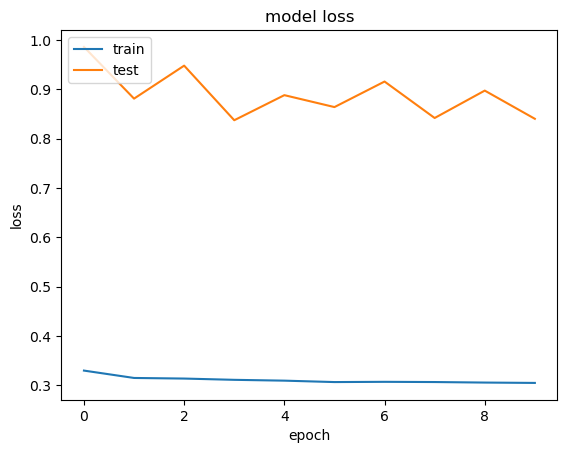

In [387]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Evaluate the model

In [388]:
def get_random_userid():
    # pick 1 random user in the training data at random
    user_id_eval = np.random.randint(num_users)
    # user_id_eval_df = users_mapping[user_id_eval]
    return user_id_eval

user_id_eval = get_random_userid()
user_id_eval

2290

In [389]:
K = 10

In [390]:
def get_y_true(user_id):
    # Stacking x_train and y_train
    y_true_tmp = np.hstack((x_train, y_train))
    # keep only the recommended games
    y_true_tmp = y_true_tmp[y_true_tmp[:,-1] == 1]
    # filtering for the user id
    y_true = y_true_tmp[y_true_tmp[:,0] == user_id][:,1]
    return y_true
    
y_true = get_y_true(user_id_eval)
y_true

array([   24,  1176,  1254,  1440,  2244,  2445,  2457,  2674,  3235,
        3822,  3891,  4306,  4566,  5832,  6898,  7747,  7882,  9401,
       10641, 11132, 12307, 13463, 13989, 14001])

In [366]:
def get_user_games(user_id):
    # Generate a list of all games for a specific user
    games = list(games_mapping.keys())
    games2pred = np.reshape(games, (-1,1))
    user_game_array_eval = np.hstack(([[user_id]] * len(games), games2pred))
    return user_game_array_eval

user_games = get_user_games(user_id_eval)
user_games

array([[  41,    0],
       [  41,    1],
       [  41,    2],
       ...,
       [  41, 8267],
       [  41, 8268],
       [  41, 8269]])

In [367]:
def get_y_pred(user_games_array, k):
    preds = model.predict(user_games_array)
    user_games_preds = np.hstack((user_games_array, preds))
    sorted_indices = np.argsort(-user_games_preds[:, -1])
    y_pred = user_games_preds[sorted_indices][:k, :]
    y_pred = y_pred[:,1].astype('int32')
    return y_pred

y_pred = get_y_pred(user_games, K)
y_pred

  1/259 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step

259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


array([1006, 2495,  659, 2746, 7144,  478, 4480,  149,  998,   26])

In [370]:
def eval_k(y_true, y_pred):
    items_relevant_user = len(y_true)
    rec_items_relevant = len(set(y_true).intersection(set(y_pred)))
    recall = rec_items_relevant / items_relevant_user
    precision = rec_items_relevant / K
    return recall, precision

eval_recall_k(y_true, y_pred) 

(0.05, 0.1)

In [394]:
def eval_k_avg(n_users, K):
    precision = []
    recall = []
    for i in range(n_users):
        user_id_eval = get_random_userid()
        y_true = get_y_true(user_id_eval)
        user_games = get_user_games(user_id_eval)
        y_pred = get_y_pred(user_games, K)
        rcl, prc = eval_k(y_true, y_pred)
        precision.append(prc)
        recall.append(rcl)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    return avg_precision, avg_recall

eval_k_avg(10, 5)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step


(0.06999999999999999, 0.01431016731016731)

In [399]:
x_test

array([[    0,  4927],
       [    1, 14542],
       [    2,  5279],
       ...,
       [ 4924, 12546],
       [ 4924,  4577],
       [ 4924, 13942]], dtype=int64)

In [410]:
def eval_hit_ratio(K, n_users):
    counter = 0
    for user_game in x_test[:n_users,:]:
        user_games = get_user_games(user_game[0])
        y_pred = get_y_pred(user_games, K)
        if(user_game[1] in y_pred):
            counter += 1
    return counter / n_users

eval_hit_ratio(30, 30)

548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━

0.06666666666666667

In [357]:
# user_game_array_eval = recommendations_sample[recommendations_sample["user_id_categorical"]==user_id_eval_df][["user_id_categorical", "app_id_categorical"]].values
# print("User", user_id_eval_df, "( corresponding to integer id",user_id_eval, ")" , "recommended these games (first 5 entries)")
# print(user_game_array_eval[:5])
# # List of only the games
# games_rec_eval = user_game_array_eval[:,1]
# print("The user", user_id_eval_df,   "recommended", len(games_rec_eval), "games")